In [37]:
import pandas as pd
base = pd.read_parquet("../Data/flights_clean.parquet")


Exploratory Data Analysi

What is the average delay and what percentage of flights depart later than scheduled?

In [38]:
# Average departure delay (in minutes)
avg_delay = base["departure_delay_minutes"].mean()

# Percentage of flights that departed later than scheduled
pct_late = (base["departure_delay_minutes"] > 0).mean() * 100

print(f"Average departure delay: {avg_delay:.2f} minutes")
print(f"Percentage of flights departing late: {pct_late:.1f}%")


Average departure delay: 21.22 minutes
Percentage of flights departing late: 49.7%


Average delay ≈ 21 minutes

~49.7% flights depart late

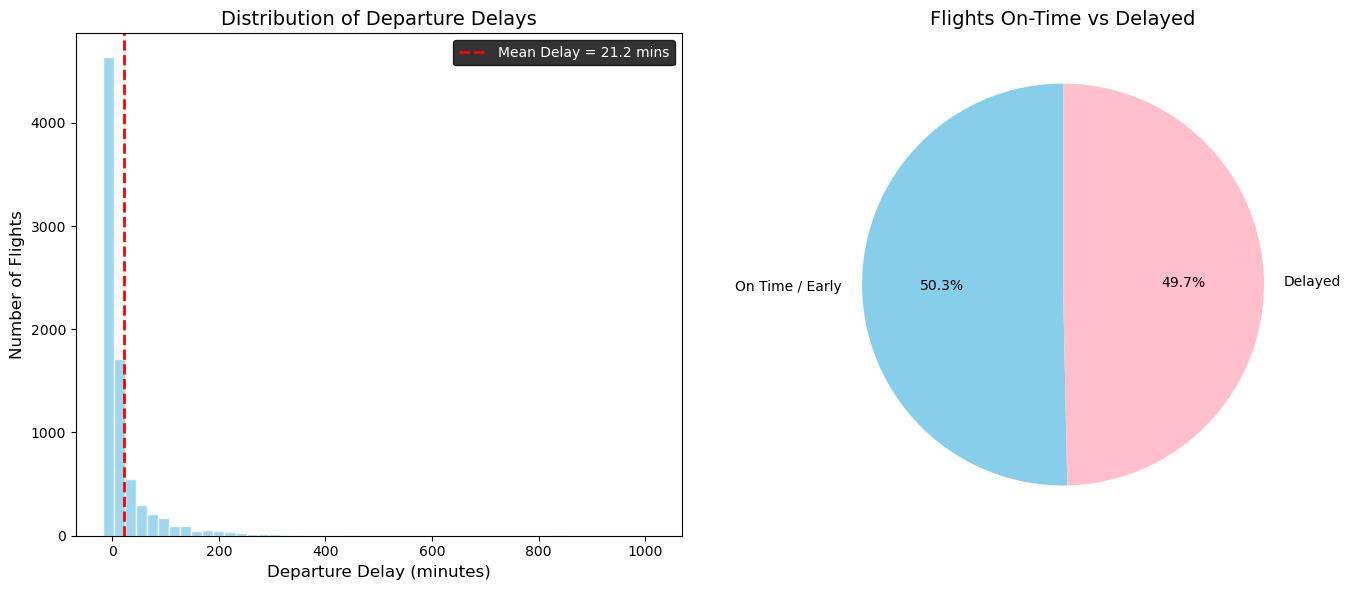

In [39]:
import matplotlib.pyplot as plt

# Prepare data
delayed = (base["departure_delay_minutes"] > 0).sum()
ontime = (base["departure_delay_minutes"] <= 0).sum()

# Create subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14,6), facecolor="white")

# Histogram (left plot)
axes[0].hist(base["departure_delay_minutes"], 
             bins=50, color="skyblue", edgecolor="white", alpha=0.8)
axes[0].axvline(base["departure_delay_minutes"].mean(), 
                color='red', linestyle='dashed', linewidth=2, 
                label=f"Mean Delay = {base['departure_delay_minutes'].mean():.1f} mins")

# Labels & formatting
axes[0].set_title("Distribution of Departure Delays", color="black", fontsize=14)
axes[0].set_xlabel("Departure Delay (minutes)", color="black", fontsize=12)
axes[0].set_ylabel("Number of Flights", color="black", fontsize=12)
axes[0].legend(facecolor="black", edgecolor="black", labelcolor="white", fontsize=10)
axes[0].tick_params(colors="black")

# Pie chart (right plot)
axes[1].pie([ontime, delayed],
            labels=["On Time / Early", "Delayed"],
            autopct="%1.1f%%",
            colors=["skyblue","pink"],
            startangle=90,
            textprops={"color":"black"})
axes[1].set_title("Flights On-Time vs Delayed", color="black", fontsize=14)

plt.tight_layout()
plt.show()


Q2. How many flights have scheduled ground time close to or below the minimum turn mins?

base["ground_time_buffer"] = base["scheduled_ground_time_minutes"] - base["minimum_turn_minutes"]


If ground_time_buffer <= 0 → flight was scheduled at or below the minimum required turnaround time (very risky).

If ground_time_buffer is small but positive (say ≤ 10 minutes), it’s “close to minimum” (also risky).

In [40]:
# Flights at or below minimum turn mins
at_or_below = (base["ground_time_buffer"] <= 0).sum()

# Flights close to minimum (say, within 10 minutes)
close_to_min = ((base["ground_time_buffer"] > 0) & (base["ground_time_buffer"] <= 12)).sum()

total_flights = base.shape[0]

print(f"Flights at/below minimum turn mins: {at_or_below} ({at_or_below/total_flights:.2%})")
print(f"Flights close to minimum (≤10 mins buffer): {close_to_min} ({close_to_min/total_flights:.2%})")


Flights at/below minimum turn mins: 637 (7.90%)
Flights close to minimum (≤10 mins buffer): 1093 (13.56%)


At/below → these are high-risk flights that don’t even meet the minimum turnaround requirement.

Close (≤10 mins) → still at risk, because any small delay can cascade.

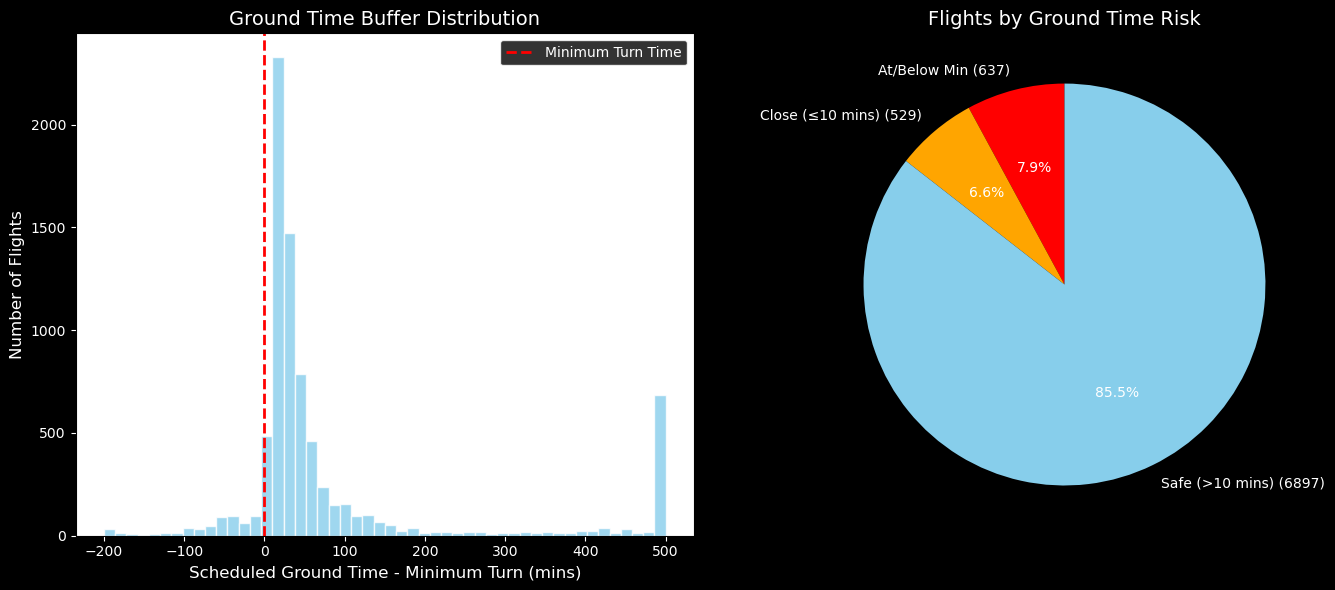

In [41]:
import matplotlib.pyplot as plt

# Counts
at_or_below = (base["ground_time_buffer"] <= 0).sum()
close_to_min = ((base["ground_time_buffer"] > 0) & (base["ground_time_buffer"] <= 10)).sum()
safe = base.shape[0] - (at_or_below + close_to_min)

# --- Plot setup ---
fig, axes = plt.subplots(1, 2, figsize=(14,6), facecolor="black")

# --- Histogram of ground time buffer ---
axes[0].hist(base["ground_time_buffer"], bins=50, color="skyblue", edgecolor="white", alpha=0.8)
axes[0].axvline(0, color="red", linestyle="dashed", linewidth=2, label="Minimum Turn Time")

axes[0].set_title("Ground Time Buffer Distribution", color="white", fontsize=14)
axes[0].set_xlabel("Scheduled Ground Time - Minimum Turn (mins)", color="white", fontsize=12)
axes[0].set_ylabel("Number of Flights", color="white", fontsize=12)
axes[0].legend(facecolor="black", edgecolor="white", labelcolor="white", fontsize=10)
axes[0].tick_params(colors="white")

# --- Pie chart of categories ---
labels = [f"At/Below Min ({at_or_below})", 
          f"Close (≤10 mins) ({close_to_min})", 
          f"Safe (>10 mins) ({safe})"]
sizes = [at_or_below, close_to_min, safe]
colors = ["red", "orange", "skyblue"]

axes[1].pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90, textprops={"color":"white"})
axes[1].set_title("Flights by Ground Time Risk", color="white", fontsize=14)

plt.tight_layout()
plt.show()


Q3. What is the average ratio of transfer bags vs. checked bags across flights?


In [43]:
avg_bag_ratio = base["bag_ratio"].mean()
print(f"Average transfer bag ratio (transfer+hot transfer / origin): {avg_bag_ratio:.2f}")


Average transfer bag ratio (transfer+hot transfer / origin): 0.82


On a typical flight, for every 100 origin bags, there are about 82 transfer bags.

That’s very high compared to point-to-point airports, where ratios are usually much lower (e.g., <0.3).

It makes sense for a hub like ORD: a huge proportion of passengers are connecting, so transfer bags dominate handling operations.

On average, flights at ORD have a transfer-to-origin bag ratio of 0.82. This means nearly one transfer bag for every origin bag, highlighting the hub’s heavy reliance on connections and the complexity it adds to operations

Q4. How do passenger loads compare across flights, and do higher loads correlate with operational difficulty?

count    8063.000000
mean        1.024249
std         0.209811
min         0.060000
25%         0.940000
50%         1.047619
75%         1.145251
max         1.895000
Name: load_factor, dtype: float64


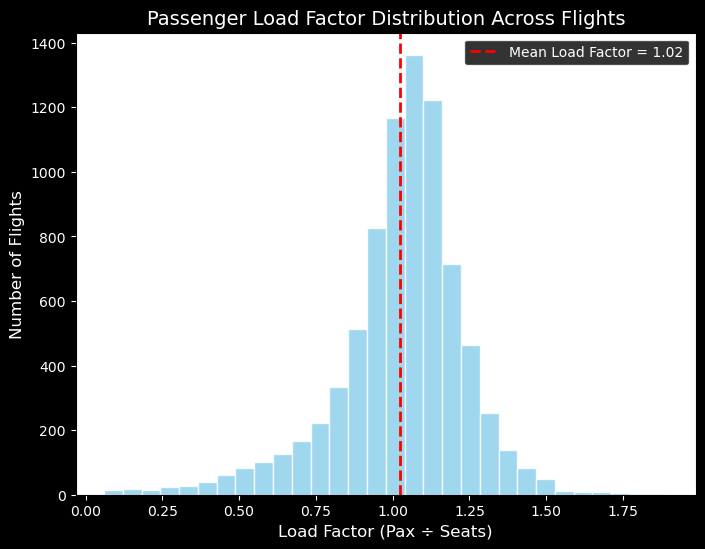

In [44]:
base["load_factor"] = base["total_pax"] / base["total_seats"]
print(base["load_factor"].describe())

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6), facecolor="black")
plt.hist(base["load_factor"], bins=30, color="skyblue", edgecolor="white", alpha=0.8)
plt.axvline(base["load_factor"].mean(), color='red', linestyle='dashed', linewidth=2, 
            label=f"Mean Load Factor = {base['load_factor'].mean():.2f}")

plt.title("Passenger Load Factor Distribution Across Flights", color="white", fontsize=14)
plt.xlabel("Load Factor (Pax ÷ Seats)", color="white", fontsize=12)
plt.ylabel("Number of Flights", color="white", fontsize=12)
plt.legend(facecolor="black", edgecolor="white", labelcolor="white")
plt.tick_params(colors="white")
plt.show()


C:\Users\nihar\AppData\Local\Temp\ipykernel_27008\3708736270.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot([base[base["load_group"]=="Low"]["departure_delay_minutes"],


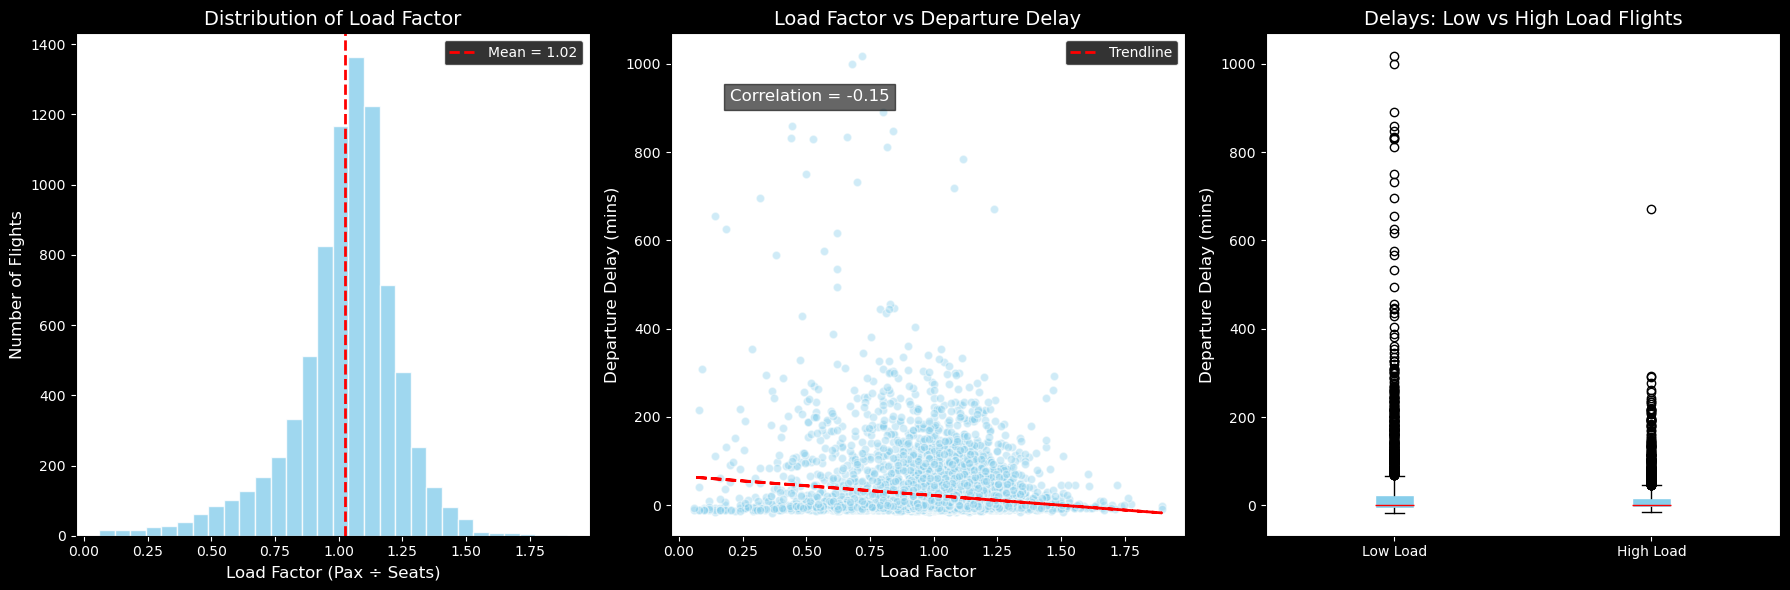

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Compute correlation
corr = base[["load_factor","departure_delay_minutes"]].corr().iloc[0,1]

# 1. Histogram + Scatter + Boxplot
fig, axes = plt.subplots(1, 3, figsize=(18,6), facecolor="black")

# --- Histogram ---
axes[0].hist(base["load_factor"], bins=30, color="skyblue", edgecolor="white", alpha=0.8)
axes[0].axvline(base["load_factor"].mean(), color='red', linestyle='dashed', linewidth=2, 
                label=f"Mean = {base['load_factor'].mean():.2f}")
axes[0].set_title("Distribution of Load Factor", color="white", fontsize=14)
axes[0].set_xlabel("Load Factor (Pax ÷ Seats)", color="white", fontsize=12)
axes[0].set_ylabel("Number of Flights", color="white", fontsize=12)
axes[0].legend(facecolor="black", edgecolor="white", labelcolor="white")
axes[0].tick_params(colors="white")

# --- Scatter Plot ---
axes[1].scatter(base["load_factor"], base["departure_delay_minutes"], 
                alpha=0.4, color="skyblue", edgecolor="white")
# Trendline
z = np.polyfit(base["load_factor"], base["departure_delay_minutes"], 1)
p = np.poly1d(z)
axes[1].plot(base["load_factor"], p(base["load_factor"]), "r--", linewidth=2, label="Trendline")

axes[1].set_title("Load Factor vs Departure Delay", color="white", fontsize=14)
axes[1].set_xlabel("Load Factor", color="white", fontsize=12)
axes[1].set_ylabel("Departure Delay (mins)", color="white", fontsize=12)
axes[1].legend(facecolor="black", edgecolor="white", labelcolor="white")
axes[1].tick_params(colors="white")

# Add correlation text inside scatter
axes[1].text(0.2, max(base["departure_delay_minutes"])*0.9, 
             f"Correlation = {corr:.2f}", 
             color="white", fontsize=12, bbox=dict(facecolor="black", alpha=0.6))

# --- Boxplot ---
base["load_group"] = pd.qcut(base["load_factor"], 4, labels=["Low","Mid-Low","Mid-High","High"])
axes[2].boxplot([base[base["load_group"]=="Low"]["departure_delay_minutes"],
                 base[base["load_group"]=="High"]["departure_delay_minutes"]],
                labels=["Low Load","High Load"], patch_artist=True,
                boxprops=dict(facecolor="skyblue", color="white"),
                medianprops=dict(color="red"))

axes[2].set_title("Delays: Low vs High Load Flights", color="white", fontsize=14)
axes[2].set_ylabel("Departure Delay (mins)", color="white", fontsize=12)
axes[2].tick_params(colors="white")

plt.tight_layout()
plt.show()


Correlation Results

Load Factor vs Departure Delay: correlation = -0.15 (slightly negative).
→ Higher load flights are not more delayed; if anything, they are slightly less delayed.

Load Factor vs Ground Time Buffer: correlation ≈ -0.02 → almost no relationship.

So, higher passenger load does not directly cause operational difficulty in your dataset.

🔹 Graphs

Histogram (left)

Distribution is tightly centered around ~1.0 → most flights are full or overbooked.

ORD is operating near capacity across flights.

Mean load factor = 1.02 (102%) → matches what hubs experience.

Scatter Plot (middle)

Shows no strong upward trend.

The red dashed line slopes slightly downward → higher load flights tend to have slightly shorter delays.

Likely because high-load flights are prioritized for on-time performance (to minimize cascading disruption).

Boxplot (right)

Low vs High load flights have similar delay medians.

Outliers exist for both groups (some flights 800–1000 min late), but not systematically worse for high-load flights.

🔹 Insight to Report

Passenger loads across flights: Most flights are near full (median load ~105%).

Correlation with difficulty: Higher loads do not correlate with greater delays or tighter ground time.

Interpretation: Operational difficulty at ORD is not driven by passenger volume directly — other factors (ground time constraints, bag ratios, SSR requests) may matter more.

Q5. Are high special service requests flights also high-delay after controlling for load?


In [52]:
# Create categories based on SSR volume
base["SSR_Group"] = pd.qcut(base["ssr_count"], q=4, labels=["Low SSR","Mid-Low SSR","Mid-High SSR","High SSR"])

# Average delay per SSR group
delay_stats = base.groupby("SSR_Group")["departure_delay_minutes"].mean()
print(delay_stats)

SSR_Group
Low SSR         20.424577
Mid-Low SSR     19.647742
Mid-High SSR    22.347099
High SSR        23.958073
Name: departure_delay_minutes, dtype: float64


C:\Users\nihar\AppData\Local\Temp\ipykernel_27008\511751379.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_stats = base.groupby("SSR_Group")["departure_delay_minutes"].mean()


In [53]:
import statsmodels.api as sm

X = base[["load_factor","ssr_count"]]
X = sm.add_constant(X)  # add intercept
y = base["departure_delay_minutes"]

model = sm.OLS(y, X).fit()
print(model.summary())


                               OLS Regression Results                              
Dep. Variable:     departure_delay_minutes   R-squared:                       0.026
Model:                                 OLS   Adj. R-squared:                  0.026
Method:                      Least Squares   F-statistic:                     107.8
Date:                     Sat, 04 Oct 2025   Prob (F-statistic):           6.08e-47
Time:                             17:50:58   Log-Likelihood:                -44635.
No. Observations:                     8063   AIC:                         8.928e+04
Df Residuals:                         8060   BIC:                         8.930e+04
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------


In [56]:
# Split by load (high vs low)
median_load = base["load_factor"].median()
low_load = base[base["load_factor"] <= median_load]
high_load = base[base["load_factor"] > median_load]

print("Low-load flights:")
print(low_load.groupby("SSR_Group")["departure_delay_minutes"].mean())

print("\nHigh-load flights:")
print(high_load.groupby("SSR_Group")["departure_delay_minutes"].mean())


Low-load flights:
SSR_Group
Low SSR         24.063793
Mid-Low SSR     24.209573
Mid-High SSR    29.054545
High SSR        32.240777
Name: departure_delay_minutes, dtype: float64

High-load flights:
SSR_Group
Low SSR         15.074144
Mid-Low SSR     15.109395
Mid-High SSR    17.232236
High SSR        20.019391
Name: departure_delay_minutes, dtype: float64


C:\Users\nihar\AppData\Local\Temp\ipykernel_27008\1957121043.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(low_load.groupby("SSR_Group")["departure_delay_minutes"].mean())
C:\Users\nihar\AppData\Local\Temp\ipykernel_27008\1957121043.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(high_load.groupby("SSR_Group")["departure_delay_minutes"].mean())


C:\Users\nihar\AppData\Local\Temp\ipykernel_27008\2925983370.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ssr_delay_means = base.groupby("SSR_Group")["departure_delay_minutes"].mean()


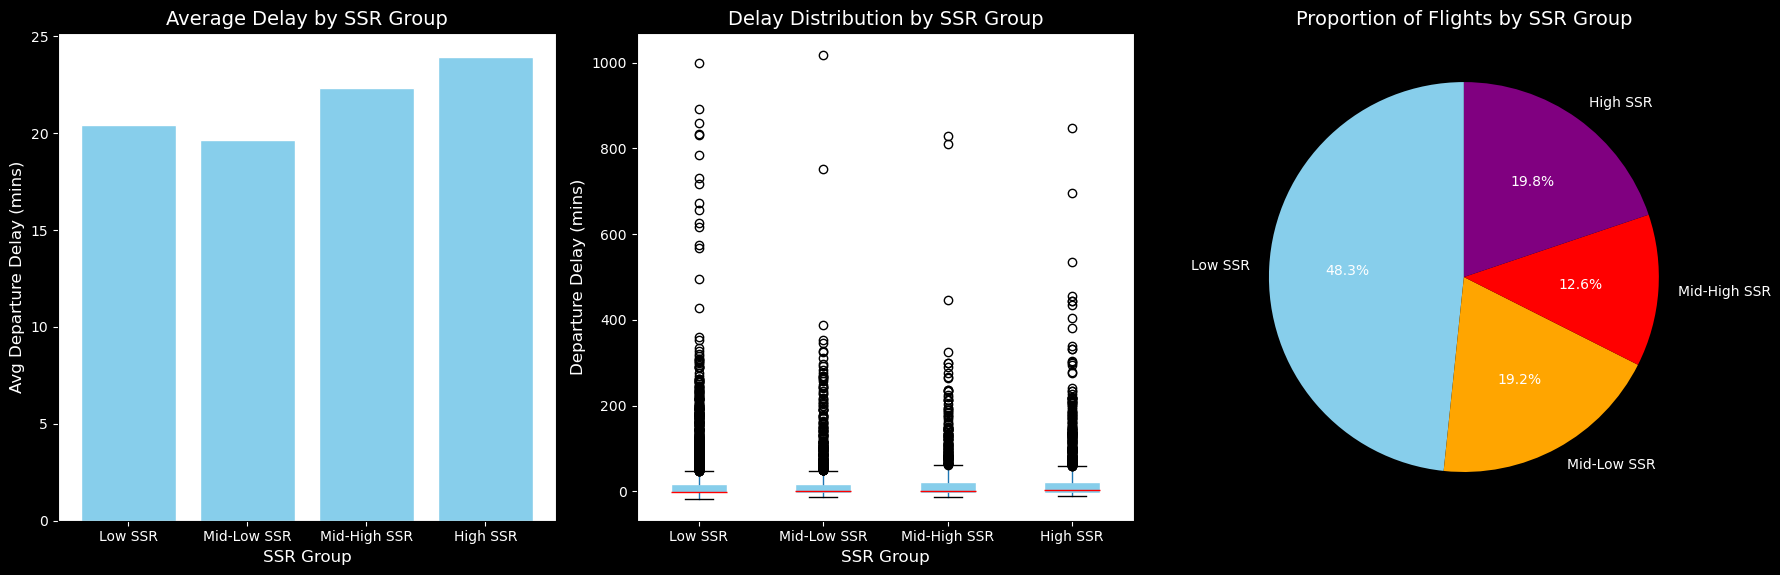

In [62]:
import matplotlib.pyplot as plt

# --- Group stats for bar & pie ---
ssr_delay_means = base.groupby("SSR_Group")["departure_delay_minutes"].mean()
ssr_counts = base["SSR_Group"].value_counts().sort_index()

# --- Setup subplots ---
fig, axes = plt.subplots(1, 3, figsize=(18,6), facecolor="black")

# 1. Bar Graph: Average Delay per SSR Group
axes[0].bar(ssr_delay_means.index, ssr_delay_means.values, color="skyblue", edgecolor="white")
axes[0].set_title("Average Delay by SSR Group", color="white", fontsize=14)
axes[0].set_xlabel("SSR Group", color="white", fontsize=12)
axes[0].set_ylabel("Avg Departure Delay (mins)", color="white", fontsize=12)
axes[0].tick_params(colors="white")

# 2. Box Plot: Delay distribution by SSR Group
base.boxplot(column="departure_delay_minutes", by="SSR_Group",
                 grid=False, patch_artist=True, ax=axes[1],
                 boxprops=dict(facecolor="skyblue", color="white"),
                 medianprops=dict(color="red"))
axes[1].set_title("Delay Distribution by SSR Group", color="white", fontsize=14)
axes[1].set_xlabel("SSR Group", color="white", fontsize=12)
axes[1].set_ylabel("Departure Delay (mins)", color="white", fontsize=12)
axes[1].tick_params(colors="white")
plt.suptitle("")  # remove default pandas title

# 3. Pie Chart: Flight share per SSR Group
axes[2].pie(ssr_counts.values, labels=ssr_counts.index,
            autopct="%1.1f%%", colors=["skyblue","orange","red","purple"],
            textprops={"color":"white"}, startangle=90)
axes[2].set_title("Proportion of Flights by SSR Group", color="white", fontsize=14)

plt.tight_layout()
plt.show()
